In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import json
from transformers import AutoTokenizer

os.chdir('../')
from notebooks_utils import read_data, plot_array



Load the data from pre-computed casual effects

Each line of the file contain `sentence`, `subject`, For each kind of casual effect: `high_score`, `low_score`, `scores` (indirect effects for each token in the sentence).

In [2]:
n_examples = "all"
parameter_size = 65
data_path = os.path.join("/home/limisiewicz/my-luster/GenderBiasGACR/results", f"results_known_{parameter_size}B_disable_mlp_{n_examples}.jsonl")

# load jsons line by line
data = []
with open(data_path, "r") as f:
    for line in f:
        data.append(json.loads(line))

load llama tokenizer

In [3]:

llama_path = f"/home/limisiewicz/my-luster/GenderBiasGACR/models/llama_{parameter_size}B"

tokenizer = AutoTokenizer.from_pretrained(llama_path , add_bos_token=False, use_fast=False)

Function aligning the scores with the positions in subject after subject

In [4]:
results = {}
kind = "null"
results[kind] = read_data(data, tokenizer, kind=kind)

Type of representation: null
Average Total Effect [ 0.01237581  0.05932666 -0.00672478]
Best average indirect effect on last subject [0.00308445 0.00960351 0.00160716]
Best average indirect effect on last token [0.0399681  0.12191363 0.00243958]
Average best-fixed score [0.07727411 0.20159094 0.04419754]
Average best-fixed on last subject token score [0.02954923 0.07096993 0.03319762]
Average best-fixed on last word score [0.0754476  0.19721978 0.03920246]
Argmax at last subject token [14 11 46]
Max at last subject token [0.02752312 0.06765518 0.03193634]
Argmax at last prompt token [74 77 18]
Max at last prompt token [0.06440677 0.1799653  0.03276875]


In [5]:
kind = "mlp"
results[kind] = read_data(data, tokenizer, kind=kind)

Type of representation: mlp
Average Total Effect [ 0.01237581  0.05932666 -0.00672478]
Best average indirect effect on last subject [0.00383522 0.0182549  0.00426315]
Best average indirect effect on last token [0.01008039 0.02583953 0.00214186]
Average best-fixed score [0.03851587 0.09876816 0.04232319]
Average best-fixed on last subject token score [0.03029631 0.0776177  0.03576214]
Average best-fixed on last word score [0.03788734 0.09486298 0.04015363]
Argmax at last subject token [6 6 6]
Max at last subject token [0.02827389 0.07630657 0.03459233]
Argmax at last prompt token [37 69 14]
Max at last prompt token [0.03451906 0.0838912  0.03247104]


In [6]:
kind = "attn"
results[kind] = read_data(data, tokenizer, kind=kind)

Type of representation: attn
Average Total Effect [ 0.01237581  0.05932666 -0.00672478]
Best average indirect effect on last subject [5.19860892e-04 8.72679841e-04 9.27629572e-05]
Best average indirect effect on last token [0.01572663 0.06053861 0.01412199]
Average best-fixed score [0.04387781 0.12547655 0.04658909]
Average best-fixed on last subject token score [0.02513522 0.05941957 0.03079554]
Average best-fixed on last word score [0.04375535 0.12527757 0.04645654]
Argmax at last subject token [20 17 33]
Max at last subject token [0.02495853 0.05892435 0.03042194]
Argmax at last prompt token [75 73 69]
Max at last prompt token [0.0401653  0.11859028 0.04445116]


In [7]:
results["null"].keys()

dict_keys(['high_score', 'low_score', 'result', 'result_std', 'size'])

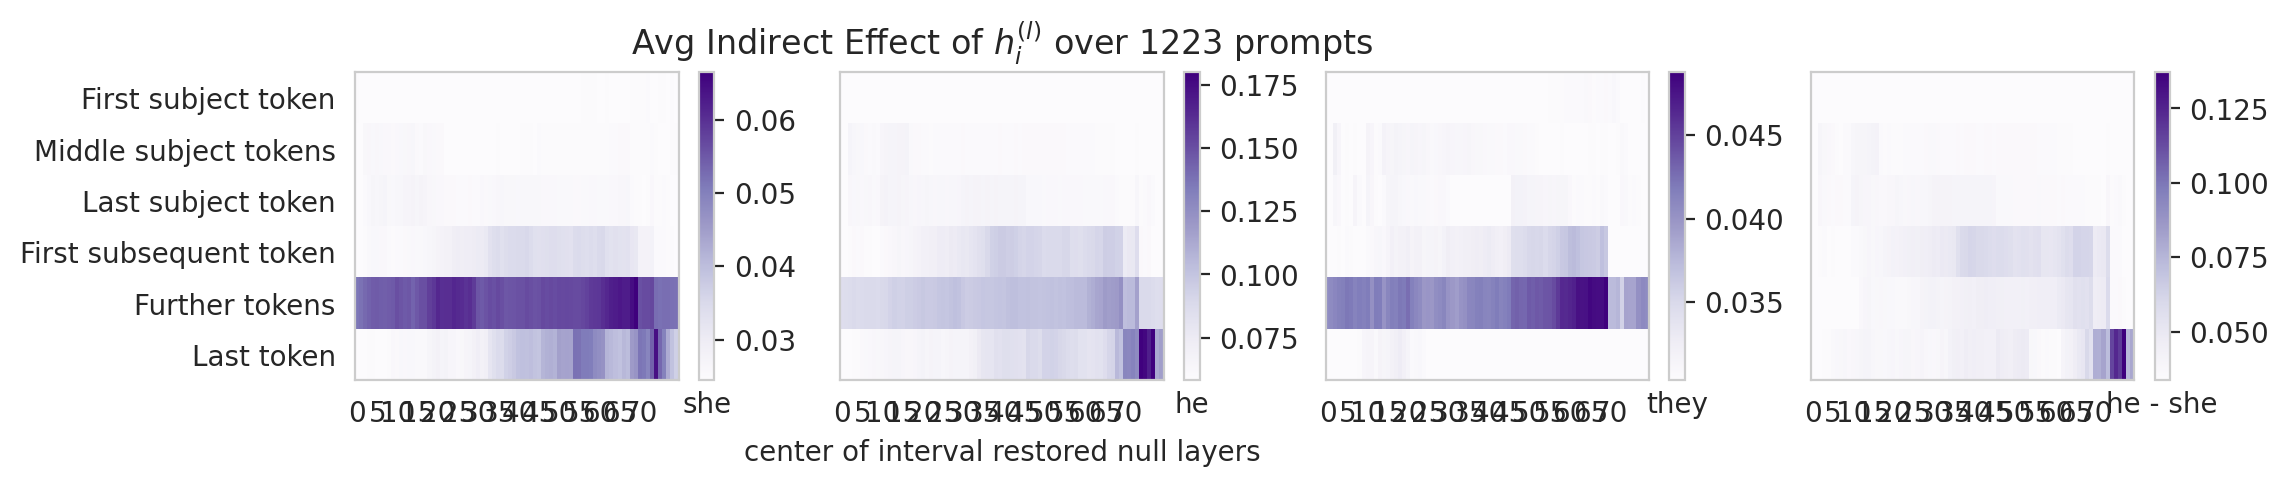

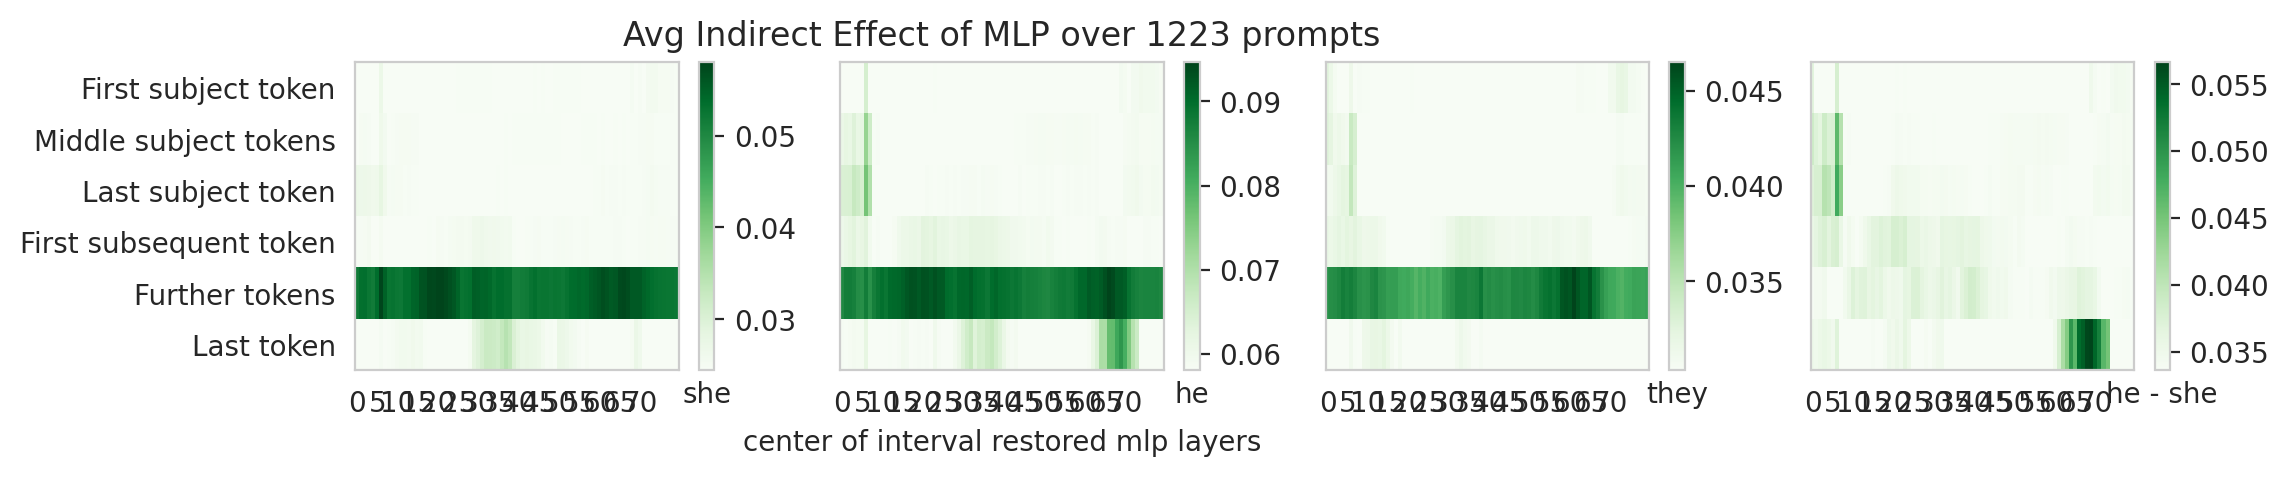

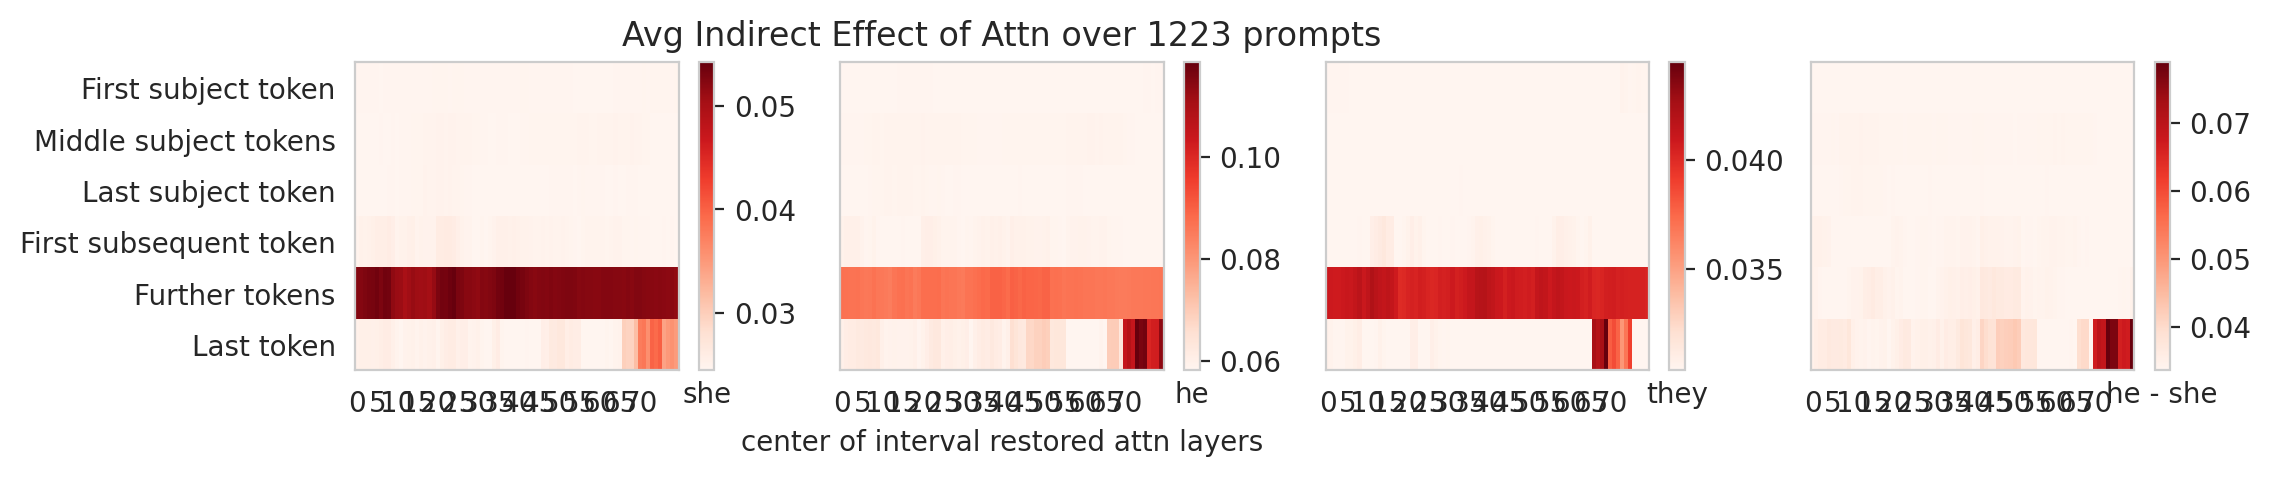

In [8]:
for kind in ["null", "mlp", "attn"]:
    d = results[kind]
    count = d["size"]
    what = {
        "null": "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }[kind]
    title = f"Avg {what} over {count} prompts"
    # result = np.clip(d["result"] - d["low_score"], 0, None)
    result = d["result"] # - d["low_score"]


    low_scores = np.append(d["low_score"], d["low_score"][1] - d["low_score"][0])
    high_scores = np.append(d["high_score"], d["high_score"][1] - d["high_score"][0])
    result = np.append(d["result"], np.expand_dims(d["result"][:,:,1]  - d["result"][:,:,0] , 2), axis=2)
    result = np.nan_to_num(result, 0)

    # if kind not in ["mlp", "attn"]:
    #     high_score = result.max()
    plot_array(
        result,
        kind=kind,
        title=title,
        all_low_scores=low_scores,
        all_high_scores=high_scores
    )

In [9]:
results["null"]["low_score"]

array([0.02443867, 0.05805167, 0.03032917])

In [10]:
results["null"]["high_score"]

array([0.03681448, 0.11737834, 0.02360439])

## Observation

After the noise intervention, on average probability of `he` hikes rapidly by 0.2, in comparison to 0.05 for `she` and about 0.03 drop for `they`.

The difference between `he` and `she` is probably caused by the over-representation of male biased/skewed words in the data.
The drop in `they` may be the result of reintroducing information that the subject is singular.
Singular usage of `they` is not common in the training data of the model (source?).

### Severing MLPs

has minor effect of indirect effect of causal intervaention on mlp or attention output. However, changes are visible when whole latent vector is restored.
Interestingly, bringing back the vector from upper layers but not the last one increases the probability of gendered prediction!
Together with the correlation results it suggest that last layers MLPs acctualy counter the gender information ...

